In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

In [3]:
x1 =[-1,-1, 1,-1, 1,-1,-1, 1]
x2 =[-1,-1,-1,-1,-1, 1,-1,-1]
x3 =[-1, 1, 1,-1,-1, 1,-1, 1]

In [4]:
samples = np.asmatrix([x1, x2, x3])

In [5]:
class HopfieldNet(object):
    def __init__(self, memory):
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
    def updateSync(self, x):
        return np.sign(np.asarray(x).dot(self.weights))

In [6]:
Net = HopfieldNet(samples)
[np.array_equal(Net.updateSync(x), np.asarray(x)) for x in samples]

[True, True, True]

The Little Model can remember the vectors used in constructing the model.

# 3.1 Convergence and attractors

In [7]:
x1d =[ 1,-1, 1, -1, 1,-1, -1, 1]
x2d =[ 1, 1,-1, -1,-1, 1, -1,-1]
x3d =[ 1, 1, 1, -1, 1, 1, -1, 1]
samples_with_error = np.asmatrix([x1d,x2d,x3d])

In [8]:
class HopfieldNet(object):
    def __init__(self, memory):
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
        self.numIterations = 0
    
    def updateSync(self, x):
        return np.sign(np.asarray(x).dot(self.weights))
    
    def updateSyncConverge(self, x):
        memory1 = self.updateSync(x)
        memory2 = self.updateSync(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 100:
                # reset numIterations
                self.numIterations = 0 
                return np.matrix(np.zeros(x.shape))
            else:
                return self.updateSyncConverge(memory2)

In [9]:
Net = HopfieldNet(samples)
[(Net.updateSyncConverge(x) in samples) for x in samples_with_error]

[True, False, False]

Only the first pattern converges to one of the memorized patterns. The other two cycles between two values.

In [10]:
from itertools import product

In [11]:
# create all combinations of 1 and -1
vector_space= np.matrix(list(product((-1, 1), repeat=8)))

In [12]:
class HopfieldNet(object):
    def __init__(self, memory):
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
        self.numIterations = 0
    
    def updateSync(self, x):
        return np.sign(np.asarray(x).dot(self.weights))
    
    def updateSyncConverge(self, x):
        memory1 = self.updateSync(x)
        memory2 = self.updateSync(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 100:
                # reset numIterations
                self.numIterations = 0 
                return np.matrix(np.zeros(x.shape))
            else:
                return self.updateSyncConverge(memory2)
            
    def findAttractorsSync(self, vector_space):
        attractors = []
        for vector in vector_space:
            converged_memory = self.updateSyncConverge(vector)
            if not any([(converged_memory == attractor).all() for attractor in attractors]):
                attractors.append(converged_memory)
        # omit the all-zero vector
        attractors = [attractor for attractor in attractors if attractor.any()]
        return attractors

In [13]:
Net = HopfieldNet(samples)
attractors = Net.findAttractorsSync(vector_space)
attractors

[matrix([[-1., -1., -1., -1., -1.,  1., -1., -1.]]),
 matrix([[-1.,  1.,  1., -1., -1.,  1., -1.,  1.]]),
 matrix([[-1., -1.,  1., -1.,  1., -1., -1.,  1.]]),
 matrix([[ 1., -1., -1.,  1.,  1., -1.,  1., -1.]]),
 matrix([[ 1.,  1., -1.,  1., -1.,  1.,  1., -1.]]),
 matrix([[ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.]])]

In [14]:
# check if the initial samples with which we built the model were included in the attractors
[any([(sample == attractor).all() for attractor in attractors]) for sample in samples]

[True, True, True]

All the initial vectors are attractors but we also have 3 more attractors in the model.

In [15]:
dissimilar_test_vector = np.asmatrix([ 1, 1,-1, 1, 1,-1, 1,-1])
dissimilar_recall = Net.updateSyncConverge(dissimilar_test_vector)

In [16]:
[attractor for attractor in attractors if (dissimilar_recall == attractor).all()]

[matrix([[ 1., -1., -1.,  1.,  1., -1.,  1., -1.]])]

When we use a dissimilar vector, the model recalls a different attractor instead.

### Try Asynch updates

In [17]:
class HopfieldNet(object):
    def __init__(self, memory):
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
        self.numIterations = 0
    
    def updateSync(self, x):
        return np.sign(np.asarray(x).dot(self.weights))
    
    def updateSyncConverge(self, x):
        memory1 = self.updateSync(x)
        memory2 = self.updateSync(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 100:
                # reset numIterations
                self.numIterations = 0 
                return np.matrix(np.zeros(x.shape))
            else:
                return self.updateSyncConverge(memory2)
            
    def findAttractorsSync(self, vector_space):
        attractors = []
        for vector in vector_space:
            converged_memory = self.updateSyncConverge(vector)
            if not any([(converged_memory == attractor).all() for attractor in attractors]):
                attractors.append(converged_memory)
        # omit the all-zero vector
        attractors = [attractor for attractor in attractors if attractor.any()]
        return attractors
    
    def update(self, x):
        copy_of_x = np.copy(x)
        for column_idx in np.random.permutation(self.weights.shape[1]):
            copy_of_x[:,column_idx] = np.sign(copy_of_x.dot(self.weights[:,column_idx]))
        return copy_of_x
    
    def updateConverge(self, x, plot=False):
        memory1 = self.update(x)
        memory2 = self.update(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 100:
                # reset numIterations
                self.numIterations = 0 
                return np.matrix(np.zeros(x.shape))
            else:
                return self.updateConverge(memory2, plot)
    
    def findAttractors(self, vector_space):
        attractors = []
        for vector in vector_space:
            converged_memory = self.updateConverge(vector)
            if not any([(converged_memory == attractor).all() for attractor in attractors]):
                attractors.append(converged_memory)
        # omit the all-zero vector
        attractors = [attractor for attractor in attractors if attractor.any()]
        return attractors

In [18]:
Net = HopfieldNet(samples)
[np.array_equal(Net.updateSync(x), np.asarray(x)) for x in samples]

[True, True, True]

Again the network is able to recall the initial vectors.

In [19]:
[print(Net.updateConverge(x)) for x in samples_with_error]
[(Net.updateConverge(x) in samples) for x in samples_with_error]

[[-1 -1  1 -1  1 -1 -1  1]]
[[ 1  1 -1  1 -1  1  1 -1]]
[[ 1  1  1  1  1 -1  1  1]]


[True, True, True]

This time the network is able to recall the original vectors for the distorted inputs.

In [20]:
Net = HopfieldNet(samples)
attractors = Net.findAttractors(vector_space)
attractors

[array([[-1, -1, -1, -1, -1,  1, -1, -1]]),
 array([[ 1, -1, -1,  1,  1, -1,  1, -1]]),
 array([[-1,  1,  1, -1, -1,  1, -1,  1]]),
 array([[-1, -1,  1, -1,  1, -1, -1,  1]]),
 array([[ 1,  1,  1,  1,  1, -1,  1,  1]]),
 array([[ 1,  1, -1,  1, -1,  1,  1, -1]])]

In [21]:
# check if the initial samples with which we built the model were included in the attractors
[any([(sample == attractor).all() for attractor in attractors]) for sample in samples]

[True, True, True]

Again, we have all the initial vectors as attractors but this time 4 more attractors in the model.

In [22]:
dissimilar_test_vector = np.asmatrix([ 1, 1,-1, 1, 1,-1, 1,-1])
dissimilar_recall = Net.updateConverge(dissimilar_test_vector)
[attractor for attractor in attractors if (dissimilar_recall == attractor).all()]

[array([[ 1, -1, -1,  1,  1, -1,  1, -1]])]

Again, when we use a dissimilar vector, the model recalls a different attractor instead.

# 3.2 Sequential Update

In [23]:
# read some data
with open('pict.dat', 'r') as File:
    output = csv.reader(File, delimiter='\t')
    for row in output:
        pictures = (np.fromstring(row[0], dtype=int, sep=','))
pictures = np.matrix(pictures.reshape((-1,1024)))

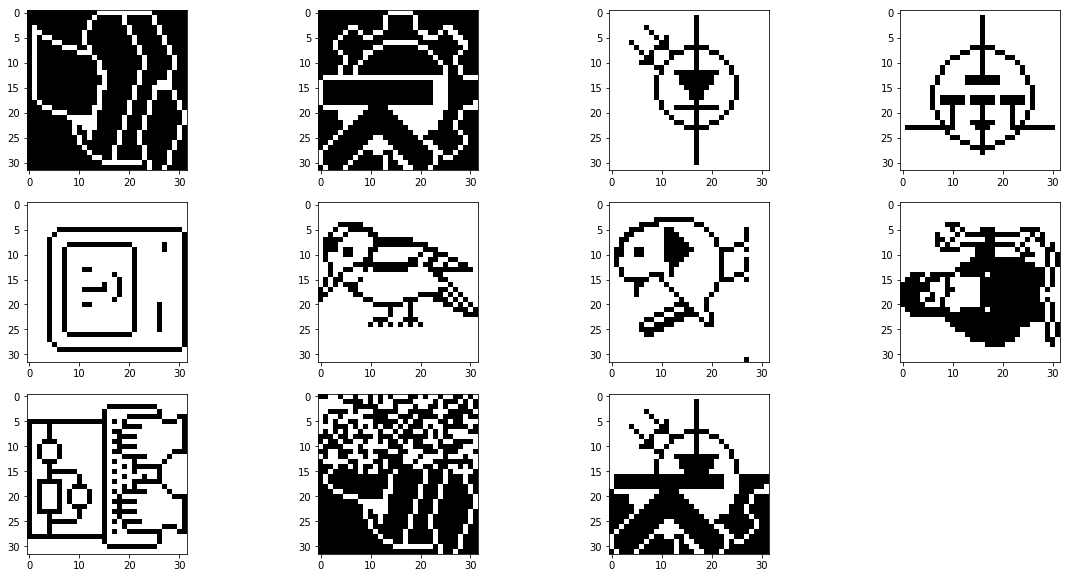

In [24]:
# show the pictures
fig = plt.figure(figsize=(20, 10))
for i in range(11):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(pictures[i,:].reshape(32,32), cmap='gray')

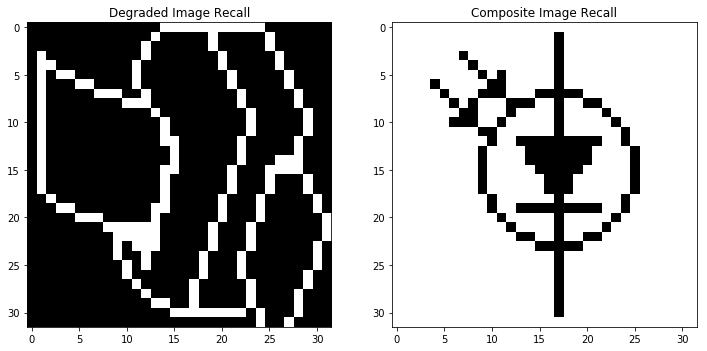

In [25]:
Net = HopfieldNet(pictures[0:3,:])
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Degraded Image Recall')
plt.imshow(Net.updateConverge(pictures[9,:]).reshape(32,32), cmap='gray')
plt.subplot(122)
plt.title('Composite Image Recall')
plt.imshow(Net.updateConverge(pictures[10,:]).reshape(32,32), cmap='gray')

Network can recall a degraded image but for a composition of two images it can recall one of them depending on the order of updates.

In [26]:
weights = (1/1024)*pictures[0:3,:].T.dot(pictures[0:3,:])
np.fill_diagonal(weights,0)

In [27]:
x = np.copy(pictures[9,:])

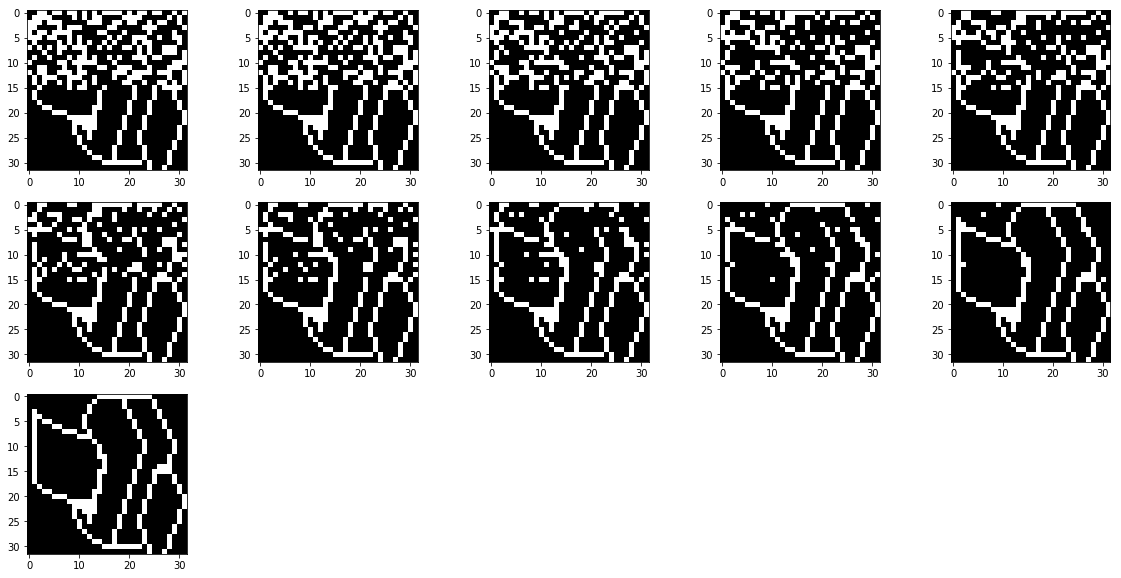

In [28]:
fig = plt.figure(figsize=(20, 10))
cnt=0
for column_idx in np.random.permutation(weights.shape[1]):
    x[:,column_idx] = np.sign(x.dot(weights[:,column_idx]))
    cnt+=1
    ax = fig.add_subplot(3,5,int(cnt/100)+1)
    ax.imshow(x.reshape(32,32), cmap='gray')

When we update the units sequentially, the image gradually becomes closer to the one in memory.

# 3.3 Energy

In [102]:
class HopfieldNet(object):
    def __init__(self, memory):
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
        self.numIterations = 0
        self.printEnergy = False
        self.energyTrajectory = []
    
    def update(self, x):
        copy_of_x = np.copy(x)
        for column_idx in np.random.permutation(self.weights.shape[1]):
            copy_of_x[:,column_idx] = np.sign(copy_of_x.dot(self.weights[:,column_idx]))
            if self.printEnergy:
                self.energyTrajectory.append(self.energy(copy_of_x))
        return copy_of_x
    
    def updateConverge(self, x, plot=False):
        memory1 = self.update(x)
        memory2 = self.update(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            #print('Converged')
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 10:
                # reset numIterations
                print('Did not converge')
                self.numIterations = 0 
                return memory2
            else:
                return self.updateConverge(memory2, plot)
    
    def findAttractors(self, vector_space):
        attractors = []
        for vector in vector_space:
            converged_memory = self.updateConverge(vector)
            if not any([(converged_memory == attractor).all() for attractor in attractors]):
                attractors.append(converged_memory)
        # omit the all-zero vector
        attractors = [attractor for attractor in attractors if attractor.any()]
        return attractors
    
    def energy(self, x):
        return -x.dot(self.weights).dot(x.T)

In [30]:
Net = HopfieldNet(pictures[0:3,:])
[Net.energy(picture) for picture in pictures]

[matrix([[-1436.390625]]),
 matrix([[-1362.640625]]),
 matrix([[-1459.25]]),
 matrix([[-717.48046875]]),
 matrix([[-522.890625]]),
 matrix([[-680.296875]]),
 matrix([[-682.73046875]]),
 matrix([[-168.546875]]),
 matrix([[-264.51171875]]),
 matrix([[-412.98046875]]),
 matrix([[-170.5]])]

Even thought the energy at different attractors are different, they are at very low values. The distorted patterns have relatively high energy values.

Converged


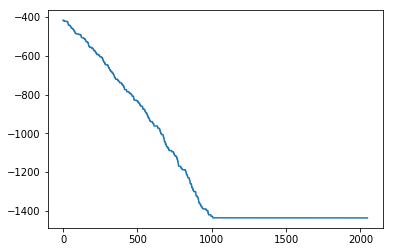

In [31]:
Net.printEnergy = True
Net.energyTrajectory = []
Net.updateConverge(pictures[9,:])
energyValues = np.asarray(Net.energyTrajectory).squeeze()
plt.plot(energyValues)

Energy is a monotonically decreasing function in steps.

Did not converge


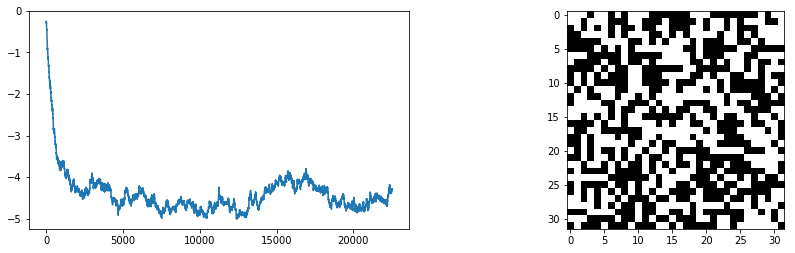

In [32]:
w = (np.random.rand(1024,1024)-0.5)/1024
Net.weights = w
Net.energyTrajectory = []
resultant_picture = Net.updateConverge(pictures[9,:])
energyValues = np.asarray(Net.energyTrajectory).squeeze()
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(energyValues)
plt.subplot(122)
plt.imshow(resultant_picture.reshape(32,32), cmap='gray')

With randomized weights the network dose not converge.

Did not converge


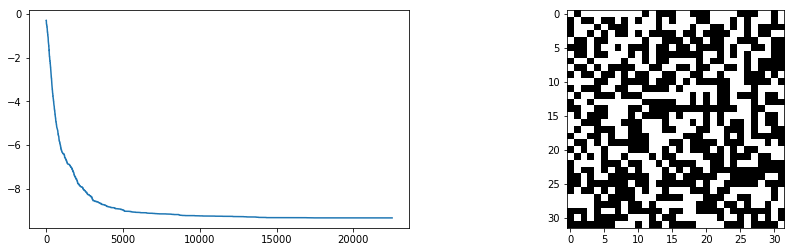

In [33]:
w = (np.random.rand(1024,1024)-0.5)/1024
w = (w+w.T)/2
Net.weights = w
Net.energyTrajectory = []
resultant_picture = Net.updateConverge(pictures[9,:])
energyValues = np.asarray(Net.energyTrajectory).squeeze()
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(energyValues)
plt.subplot(122)
plt.imshow(resultant_picture.reshape(32,32), cmap='gray')

However, when the network is  symmetrical (even if random), it does converge to some random memory. This is because any update reduces the energy in a network with symmetrical weights.

# 3.4 Distortion Resistance

In [34]:
def flip(n, x):
    length = x.shape[1]
    flipper = (np.random.binomial(1, 1-n/length, length)*2-1).reshape(x.shape)
    return np.multiply(x,flipper)

In [35]:
flip(2,pictures[0,:])

matrix([[-1, -1, -1, ..., -1, -1, -1]])

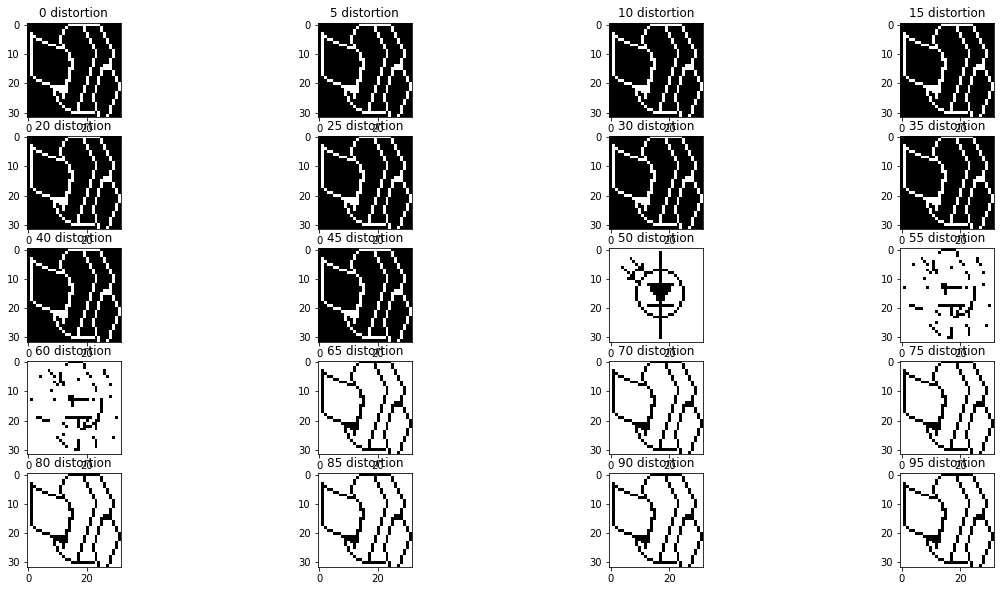

In [47]:
np.random.seed(1)
Net = HopfieldNet(pictures[0:3,:])
fig = plt.figure(figsize=(20, 10))
for i in range(20):
    input_pic = flip((1024/100)*(i*5),pictures[0,:])
    resultant_picture = Net.updateConverge(input_pic)
    ax = fig.add_subplot(5,4,i+1)
    plt.title("%i distortion" % (i*5))
    ax.imshow(resultant_picture.reshape(32,32), cmap='gray')

In the 30% to 50% range the distortions make the network recall other attractors. Somehow, the inverted image is also an attractor and the network starts to recall that with high flipping ratios.

# 3.5 Capacity

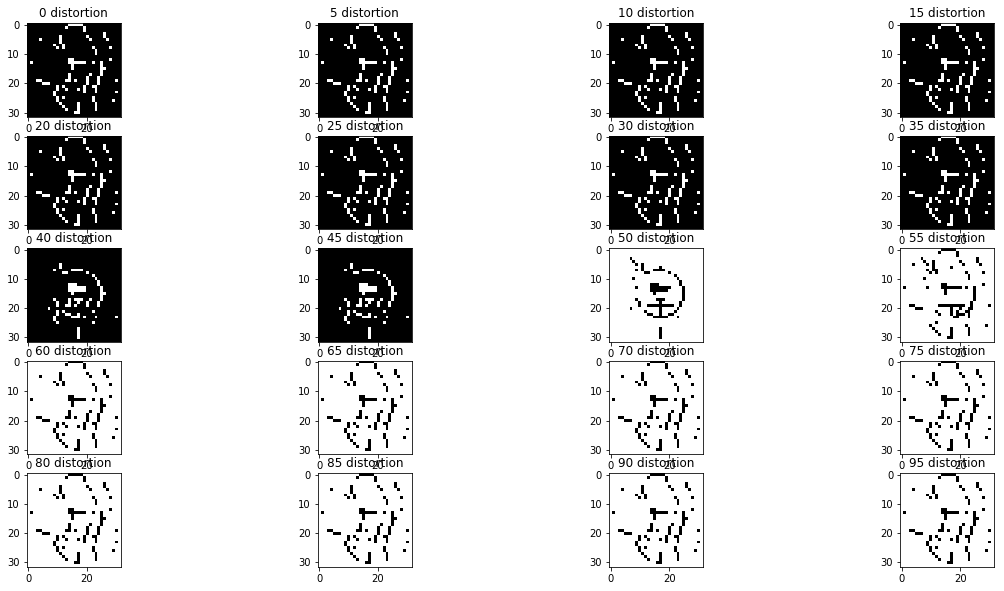

In [103]:
np.random.seed(1)
Net = HopfieldNet(pictures[0:4,:])
fig = plt.figure(figsize=(20, 10))
for i in range(20):
    input_pic = flip((1024/100)*(i*5),pictures[0,:])
    resultant_picture = Net.updateConverge(input_pic)
    ax = fig.add_subplot(5,4,i+1)
    plt.title("%i distortion" % (i*5))
    ax.imshow(resultant_picture.reshape(32,32), cmap='gray')

Even adding just one more sample makes the network collapse. The performance drop is abrupt.

In [279]:
def numRecalled(Net, random_vecs):
    recalled = []
    for random_vec in random_vecs:
        result_vec = Net.update(random_vec[np.newaxis])
        recalled.append((result_vec == random_vec).all())
    return sum(recalled)

In [289]:
np.random.seed(5)
random_vecs = np.unique(np.random.binomial(1,0.5,(400,100)), axis=0)*2-1
random_vecs = random_vecs[0:300]

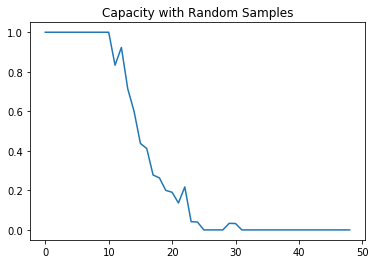

In [290]:
capacity = []
for i in range(1,50):
    Net = HopfieldNet(random_vecs[0:i,:])
    capacity.append(numRecalled(Net, random_vecs[0:i,:])/i)
plt.plot(capacity)
plt.title('Capacity with Random Samples')

Capacity with random samples is in line with the $0.138N$ capacity estimate. Random patterns are stored more easily. This may be because pictures have inherently higher correlation with each other and thus have larger [crosstalk](https://www.doc.ic.ac.uk/~ae/papers/Hopfield-networks-15.pdf).

In [291]:
np.random.seed(5)
random_vecs  = np.unique(np.sign(0.5+np.random.randn(300,100)), axis=0)
random_vecs = random_vecs[0:300]

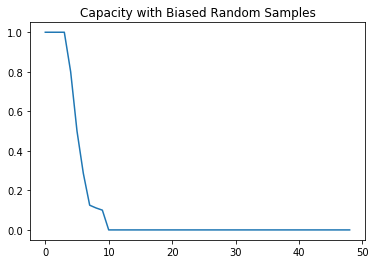

In [292]:
capacity = []
for i in range(1,50):
    Net = HopfieldNet(random_vecs[0:i,:])
    capacity.append(numRecalled(Net, random_vecs[0:i,:])/i)
plt.plot(capacity)
plt.title('Capacity with Biased Random Samples')

Capacity is reduced as the correlation between samples have been increased by adding bias.

# 3.6 Sparse Patterns

In [293]:
class HopfieldNet(object):
    def __init__(self, memory, useSparsity=False):        
        self.weights = (1/memory.shape[1])*memory.T.dot(memory)
        np.fill_diagonal(self.weights,0)
        self.numIterations = 0
        self.printEnergy = False
        self.energyTrajectory = []
        self.useSparsity = useSparsity 
        if self.useSparsity:
            self.ro = memory.mean()
            self.weights = (memory - self.ro).T.dot(memory - self.ro)
            np.fill_diagonal(self.weights,0)
    
    def update(self, x, theta=0):
        copy_of_x = np.copy(x)
        for column_idx in np.random.permutation(self.weights.shape[1]):
            if self.useSparsity:
                copy_of_x[:,column_idx] = 0.5 + 0.5*np.sign(copy_of_x.dot(self.weights[:,column_idx]) - theta)
            else:
                copy_of_x[:,column_idx] = np.sign(copy_of_x.dot(self.weights[:,column_idx]))
            if self.printEnergy:
                self.energyTrajectory.append(self.energy(copy_of_x))
        return copy_of_x
    
    def updateConverge(self, x, plot=False):
        memory1 = self.update(x)
        memory2 = self.update(memory1)
        if np.array_equal(memory1,memory2):
            # reset numIterations
            #print('Converged')
            self.numIterations = 0
            return memory1
        else:
            self.numIterations += 1
            if self.numIterations > 10:
                # reset numIterations
                print('Did not converge')
                self.numIterations = 0 
                return memory2
            else:
                return self.updateConverge(memory2, plot)
    
    def findAttractors(self, vector_space):
        attractors = []
        for vector in vector_space:
            converged_memory = self.updateConverge(vector)
            if not any([(converged_memory == attractor).all() for attractor in attractors]):
                attractors.append(converged_memory)
        # omit the all-zero vector
        attractors = [attractor for attractor in attractors if attractor.any()]
        return attractors
    
    def energy(self, x):
        return -x.dot(self.weights).dot(x.T)

In [294]:
def numRecalledSparse(Net, random_vecs, theta):
    recalled = []
    for random_vec in random_vecs:
        result_vec = Net.update(random_vec[np.newaxis], theta)
        recalled.append((result_vec == random_vec).all())
    return sum(recalled)

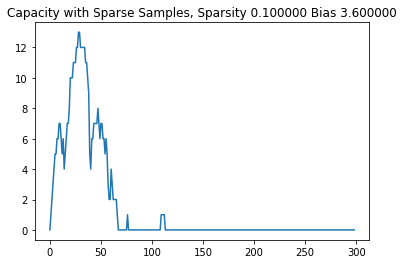

In [359]:
np.random.seed(1)
sparsity = 0.10
random_vecs = np.unique(np.random.binomial(1,sparsity,(400,100)), axis=0)
random_vecs = random_vecs[0:300]

capacity = []
theta = 3.6
for i in range(1,300):
    Net = HopfieldNet(random_vecs[0:i,:], useSparsity=True)
    capacity.append(numRecalledSparse(Net, random_vecs[0:i,:],theta))
plt.plot(capacity)
plt.title('Capacity with Sparse Samples, Sparsity %f Bias %f' % (sparsity, theta))

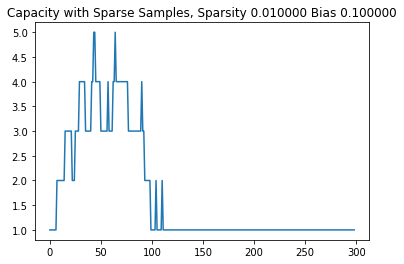

In [361]:
np.random.seed(1)
sparsity = 0.01
random_vecs = np.unique(np.random.binomial(1,sparsity,(400,100)), axis=0)
random_vecs = random_vecs[0:300]

capacity = []
theta = 0.1
for i in range(1,300):
    Net = HopfieldNet(random_vecs[0:i,:], useSparsity=True)
    capacity.append(numRecalledSparse(Net, random_vecs[0:i,:],theta))
plt.plot(capacity)
plt.title('Capacity with Sparse Samples, Sparsity %f Bias %f' % (sparsity, theta))

By increasing the bias, we can increase the capacity of the network. However, using a sparse network it is not guaranteed that the first few samples thought to the network will be stable points.

In [362]:
def capacityWithTheta(random_vecs, theta):
    capacity = []
    for i in range(1,100):
        Net = HopfieldNet(random_vecs[0:i,:], useSparsity=True)
        capacity.append(numRecalledSparse(Net, random_vecs[0:i,:],theta))
    return max(capacity)

In [367]:
np.random.seed(1)
sparsity = 0.10
random_vecs = np.unique(np.random.binomial(1,sparsity,(400,100)), axis=0)
random_vecs = random_vecs[0:300]
dump = [capacityWithTheta(random_vecs, theta) for theta in np.arange(0,4,0.1)]

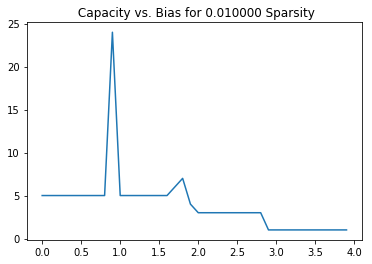

In [364]:
plt.plot( np.arange(0,4,0.1), dump)
plt.title(' Capacity vs. Bias for %f Sparsity' % sparsity)

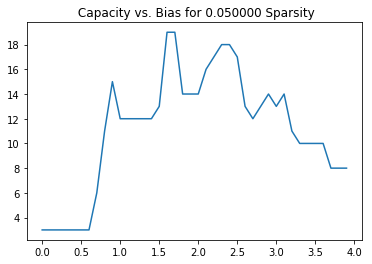

In [366]:
plt.plot( np.arange(0,4,0.1), dump)
plt.title(' Capacity vs. Bias for %f Sparsity' % sparsity)

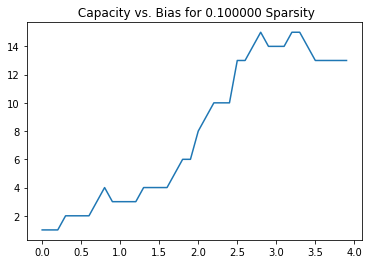

In [368]:
plt.plot( np.arange(0,4,0.1), dump)
plt.title(' Capacity vs. Bias for %f Sparsity' % sparsity)

As seen from the graphs, by playing with the sparsity of the input data we can increase network capacity. Capacity increases with sparseness. But with sparser samples, it may be a challenge to find the right bias values to get the most out of the network.